The full thing!

# Setup

In [5]:
import numpy as np

import scipy.special

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from library.datasets import Signal_Images_Dataset, Bootstrapped_Unbinned_Signal_Dataset, Binned_Signal_Dataset
from library.nn_training import select_device, train_and_eval, Custom_Model
from library.plotting import plot_loss_curves, setup_high_quality_mpl_params, plot_prediction_linearity, make_plot_note, plot_volume_slices


In [6]:
device = select_device()

Device:  cuda


# Generator Level

## Shawn's Method

### Model Training

#### Generate Datasets

In [ ]:
level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"
std_scale = True
q_squared_veto = True
balanced_classes = True
num_sets_per_label = 50
n_bins = 10

for num_events_per_set in [70_000, 24_000, 6_000]:

    name = f"signal_images_{num_events_per_set}"

    datasets = {
        "train": Signal_Images_Dataset(name=name, level=level, split="train", save_dir=save_dir),
        "eval": Signal_Images_Dataset(name=name, level=level, split="eval", save_dir=save_dir),
    }

    datasets["train"].generate(
        raw_trials=range(1,21), 
        raw_signal_dir=raw_signal_dir,
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        n_bins=n_bins,
        q_squared_veto=q_squared_veto,
        std_scale=std_scale,
        balanced_classes=balanced_classes,
    )
    datasets["eval"].generate(
        raw_trials=range(21,41), 
        raw_signal_dir=raw_signal_dir,
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        n_bins=n_bins,
        q_squared_veto=q_squared_veto,
        std_scale=std_scale,
        balanced_classes=balanced_classes,
    )

Peek at features

In [ ]:
dset = Signal_Images_Dataset(
    name="signal_images_24000", 
    level="gen", split="train", 
    save_dir="../../state/new_physics/data/processed"
)
dset.load()

plot_volume_slices(
     dset.features[0], 
     n_slices=3, 
     note=r"$\delta C_9$ : "+f"{dset.labels[0]}"
)
# plt.savefig(f"{i}", bbox_inches="tight")
plt.show()
plt.close()

#### Model Definition

In [7]:
class Res_Block(nn.Module):
    def __init__(self, in_out_channels):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv3d(
                in_channels=in_out_channels, 
                out_channels=in_out_channels, 
                kernel_size=3, stride=1, padding="same"
            ),
            # nn.BatchNorm3d(num_features=in_out_channels),
            nn.ReLU(),
            nn.Conv3d(
                in_channels=in_out_channels, 
                out_channels=in_out_channels, 
                kernel_size=3, stride=1, padding="same"
            ),
            # nn.BatchNorm3d(num_features=in_out_channels),
        )
        self.last_activation = nn.ReLU()
    
    def forward(self, x):
        x = self.block(x) + x
        x = self.last_activation(x)
        return x


class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        
        self.block_a = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=3, stride=1, padding="same"
            ),
            # nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(
                in_channels=out_channels, 
                out_channels=out_channels, 
                kernel_size=3, stride=1, padding="same"
            ),
            # nn.BatchNorm3d(num_features=out_channels),
        )
        
        self.block_b = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            # nn.BatchNorm3d(num_features=out_channels),
        )
        
        self.last_activation = nn.ReLU()
    
    def forward(self, x):
        out_block_a = self.block_a(x)
        out_block_b = self.block_b(x)
        x = out_block_a + out_block_b
        x = self.last_activation(x)
        return x


class CNN_Res(Custom_Model):
    
    def __init__(self, nickname, model_dir,):
        super().__init__(nickname, model_dir)

        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding="same", bias=False),
            # nn.BatchNorm3d(num_features=16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=1, padding=1),
            *[Res_Block(in_out_channels=16) for _ in range(3)],
            Conv_Block(in_channels=16, out_channels=16),
            *[Res_Block(in_out_channels=16) for _ in range(3)],
            Conv_Block(in_channels=16, out_channels=16),
            *[Res_Block(in_out_channels=16) for _ in range(3)],
            # Conv_Block(in_channels=128, out_channels=128),
            # *[Res_Block(in_out_channels=128) for _ in range(1)],
        )

        self.dense = nn.Sequential(
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=1),
        )
        
        self.double()

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=(2,3,4))
        x = self.dense(x)
        x = torch.squeeze(x)
        return x

#### Training

In [ ]:
learning_rate = 4e-4
epochs = 80
train_batch_size = 32
eval_batch_size = 32

for num_events_per_set in [70_000, 24_000, 6_000]:

    nickname = f"cnn_res_v2_{num_events_per_set}"
    print("Training: ", nickname)

    model = CNN_Res(nickname, "../../state/new_physics/models")

    loss_fn = nn.L1Loss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_dataset = Signal_Images_Dataset(
        name=f"signal_images_{num_events_per_set}", 
        level="gen", split="train", 
        save_dir="../../state/new_physics/data/processed"
    )
    eval_dataset = Signal_Images_Dataset(
        name=f"signal_images_{num_events_per_set}", 
        level="gen", split="eval", 
        save_dir="../../state/new_physics/data/processed"
    )
    train_dataset.load()
    eval_dataset.load()
    train_dataset.to(device)
    eval_dataset.to(device)

    train_and_eval(
        model, 
        train_dataset, eval_dataset, 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler=ReduceLROnPlateau(optimizer, factor=0.9, patience=1),
        checkpoint_epochs=5,
    )

    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(
        model.loss_table["epoch"][plot_epoch_start:], 
        model.loss_table["train_loss"][plot_epoch_start:], 
        model.loss_table["eval_loss"][plot_epoch_start:], 
        ax
    )
    ax.set_yscale("log")
    plt.show()
    plt.close()

### Evaluation

#### Linearity

Loaded features of shape: torch.Size([2200, 1, 10, 10, 10]).
Loaded labels of shape: torch.Size([2200]).
Sent features and labels to cuda.
mse: 0.02143928147336449
mae: 0.1150191284069916


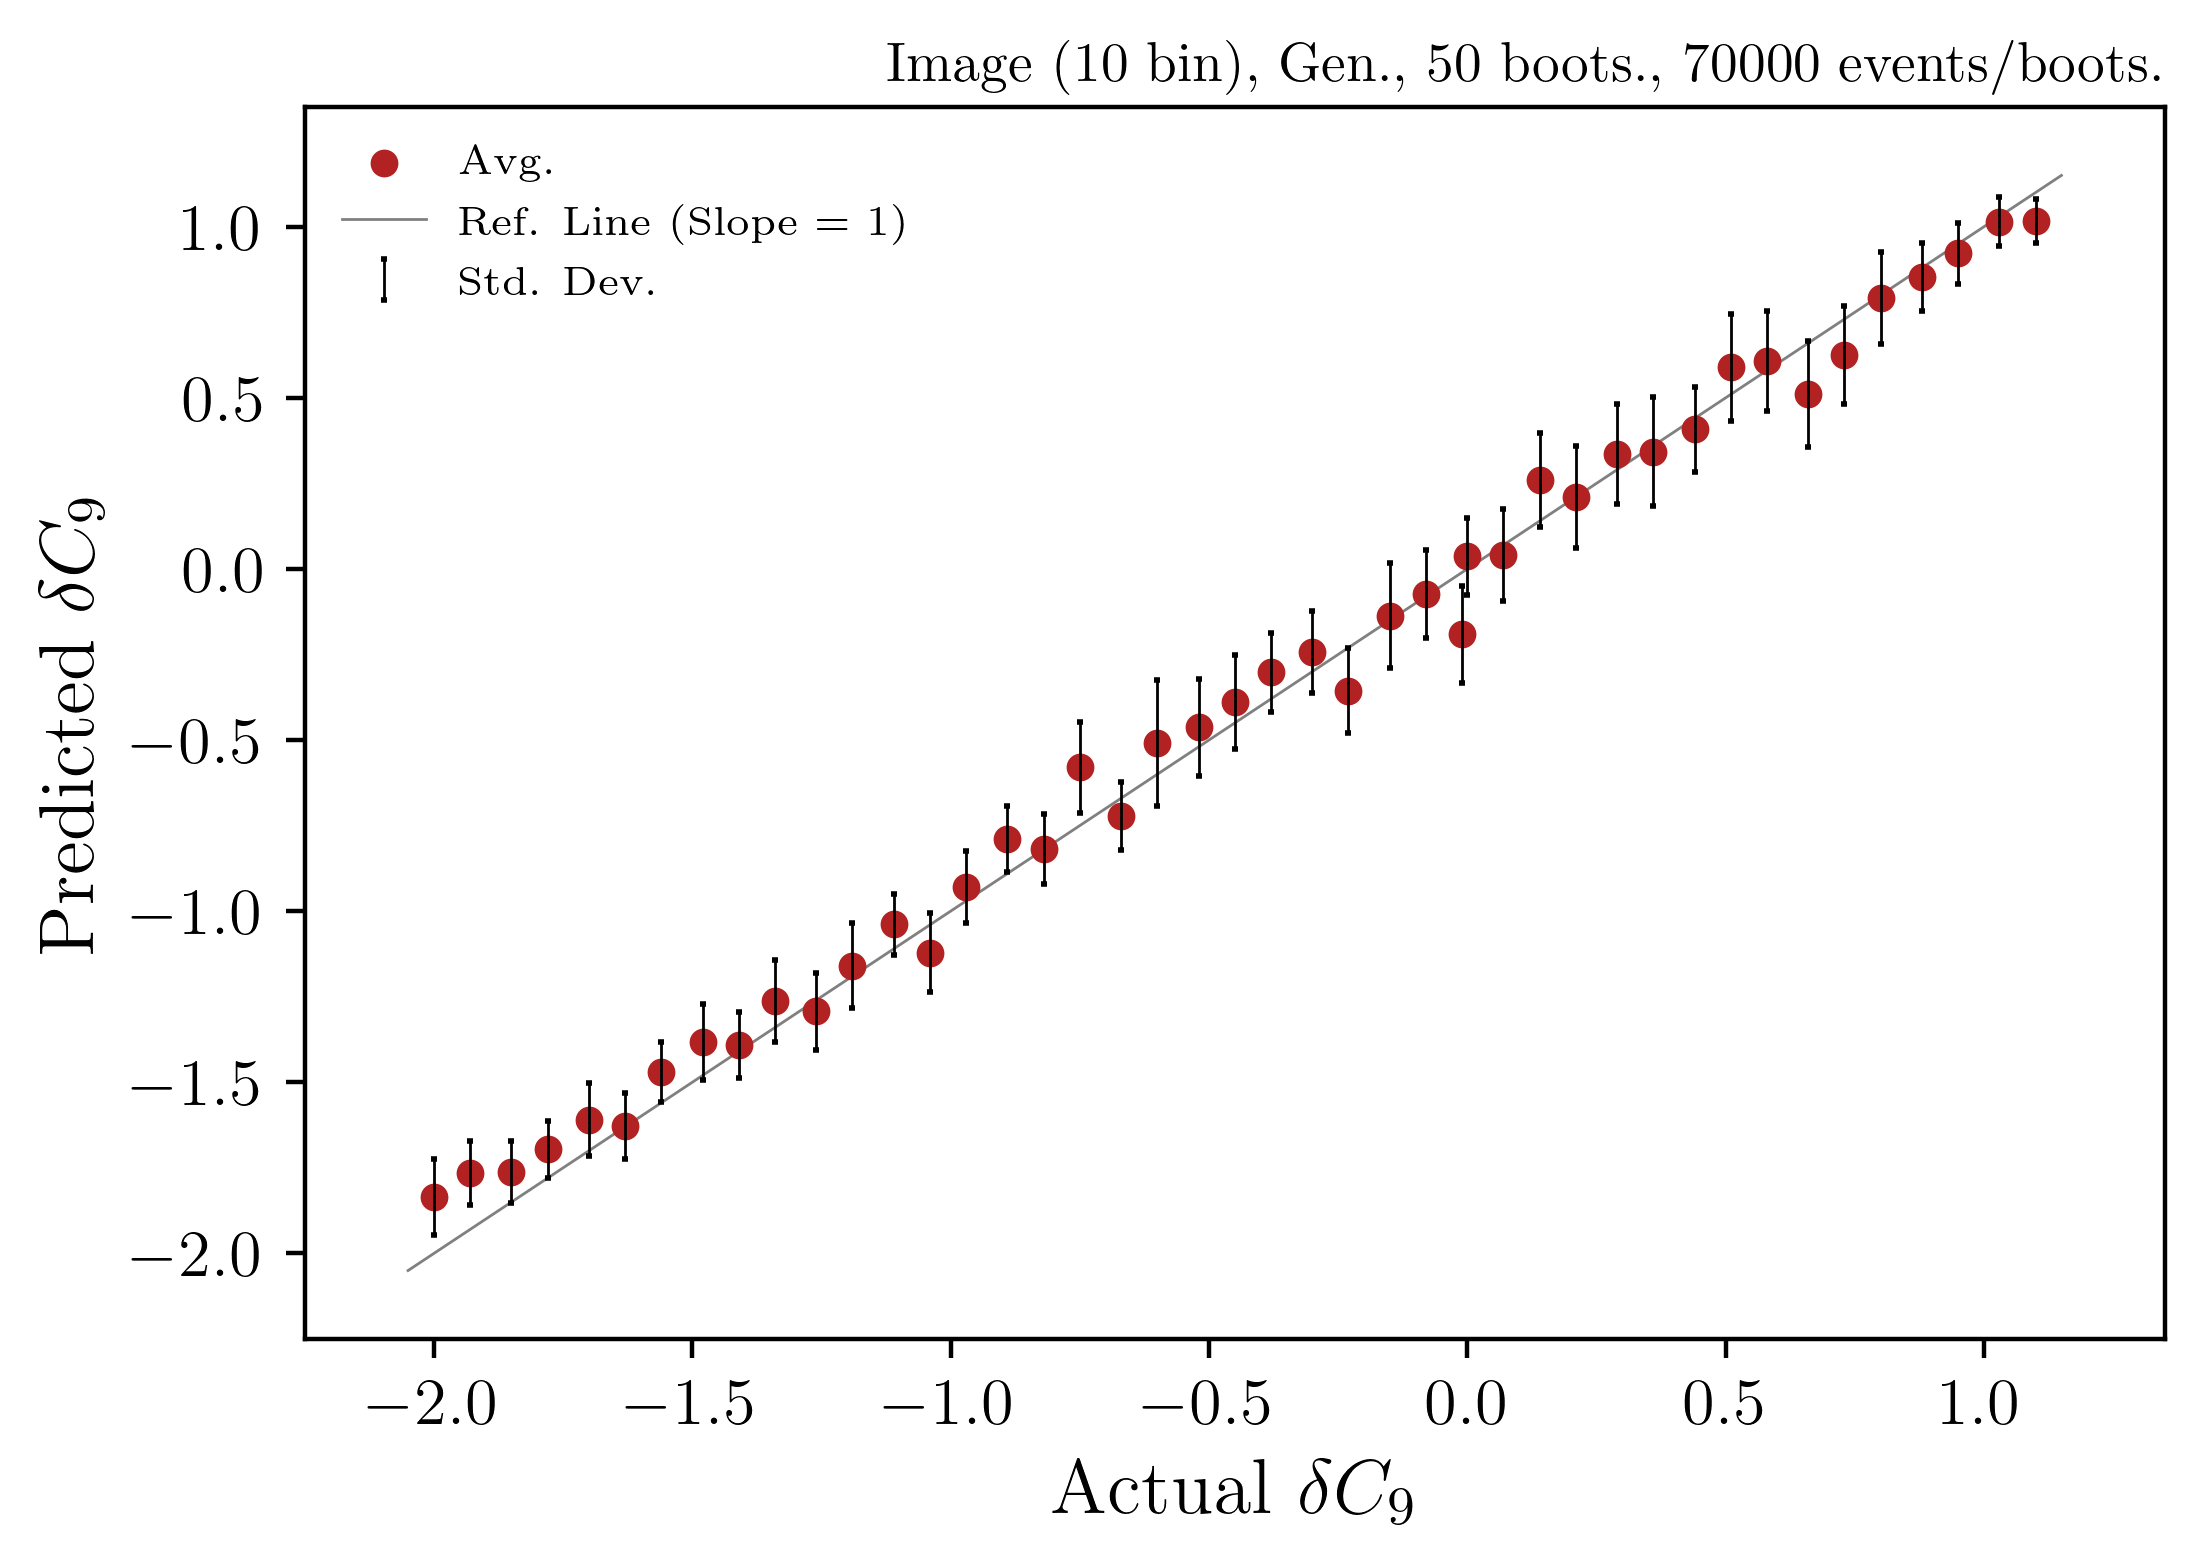

Loaded features of shape: torch.Size([2200, 1, 10, 10, 10]).
Loaded labels of shape: torch.Size([2200]).
Sent features and labels to cuda.
mse: 0.033142221568480505
mae: 0.14356285971591914


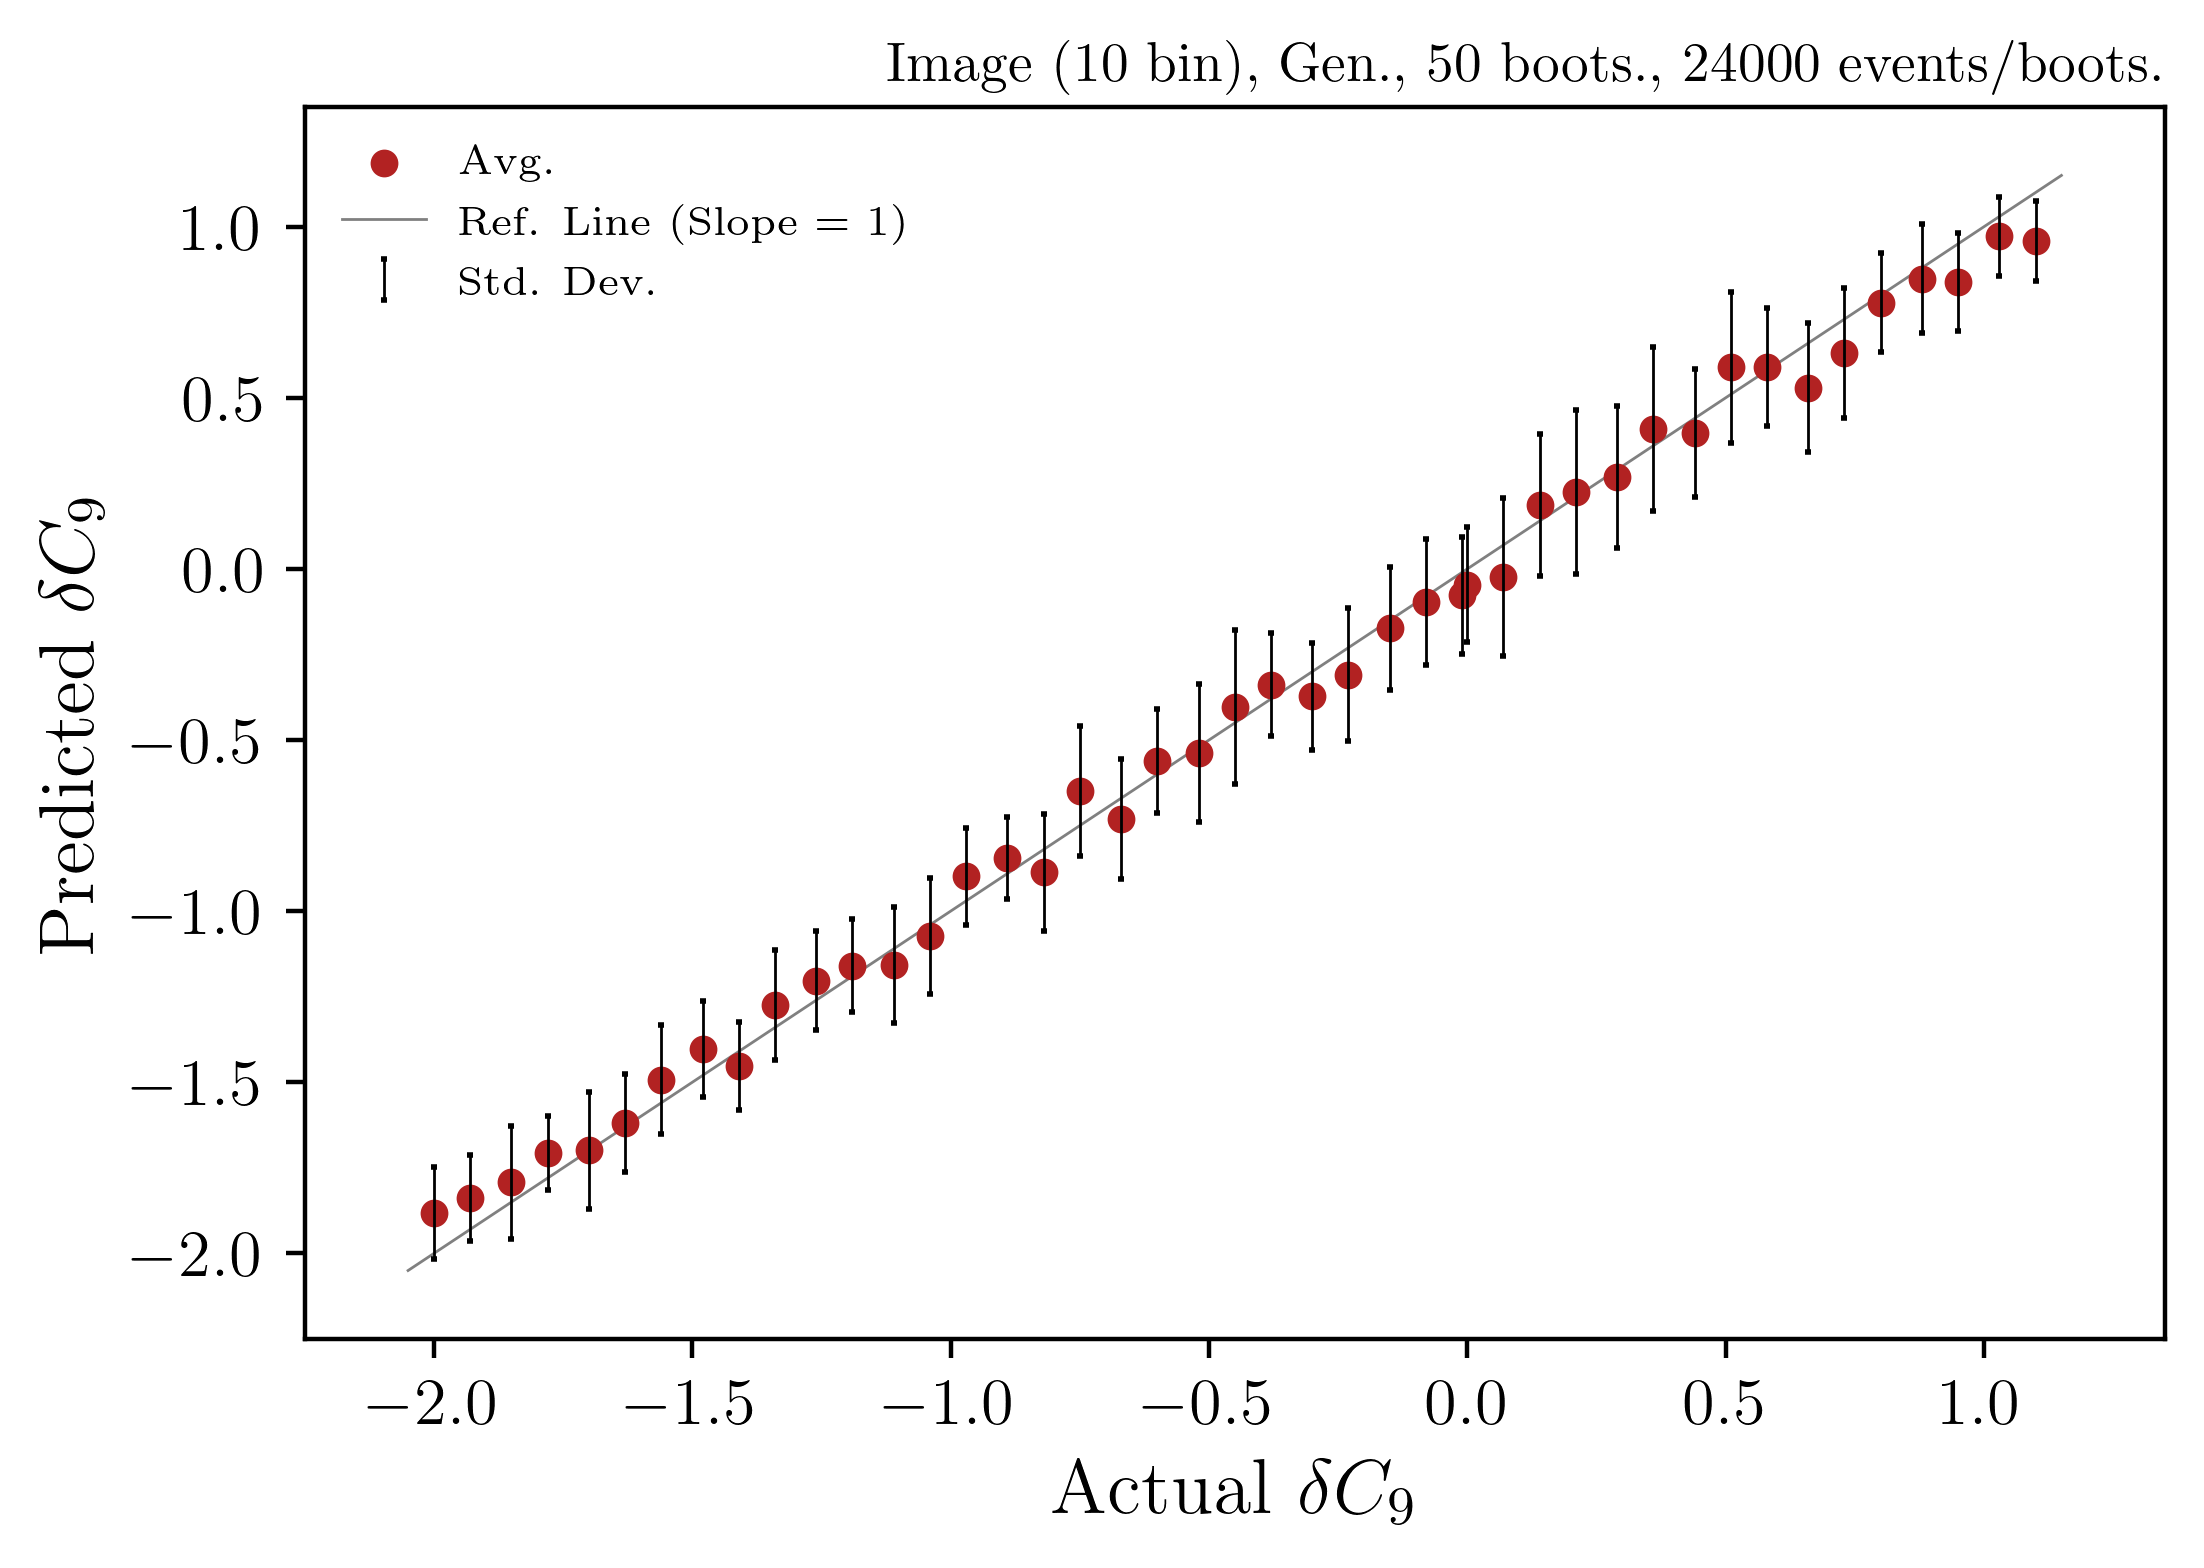

Loaded features of shape: torch.Size([2200, 1, 10, 10, 10]).
Loaded labels of shape: torch.Size([2200]).
Sent features and labels to cuda.
mse: 0.12722855051601087
mae: 0.27668465233929623


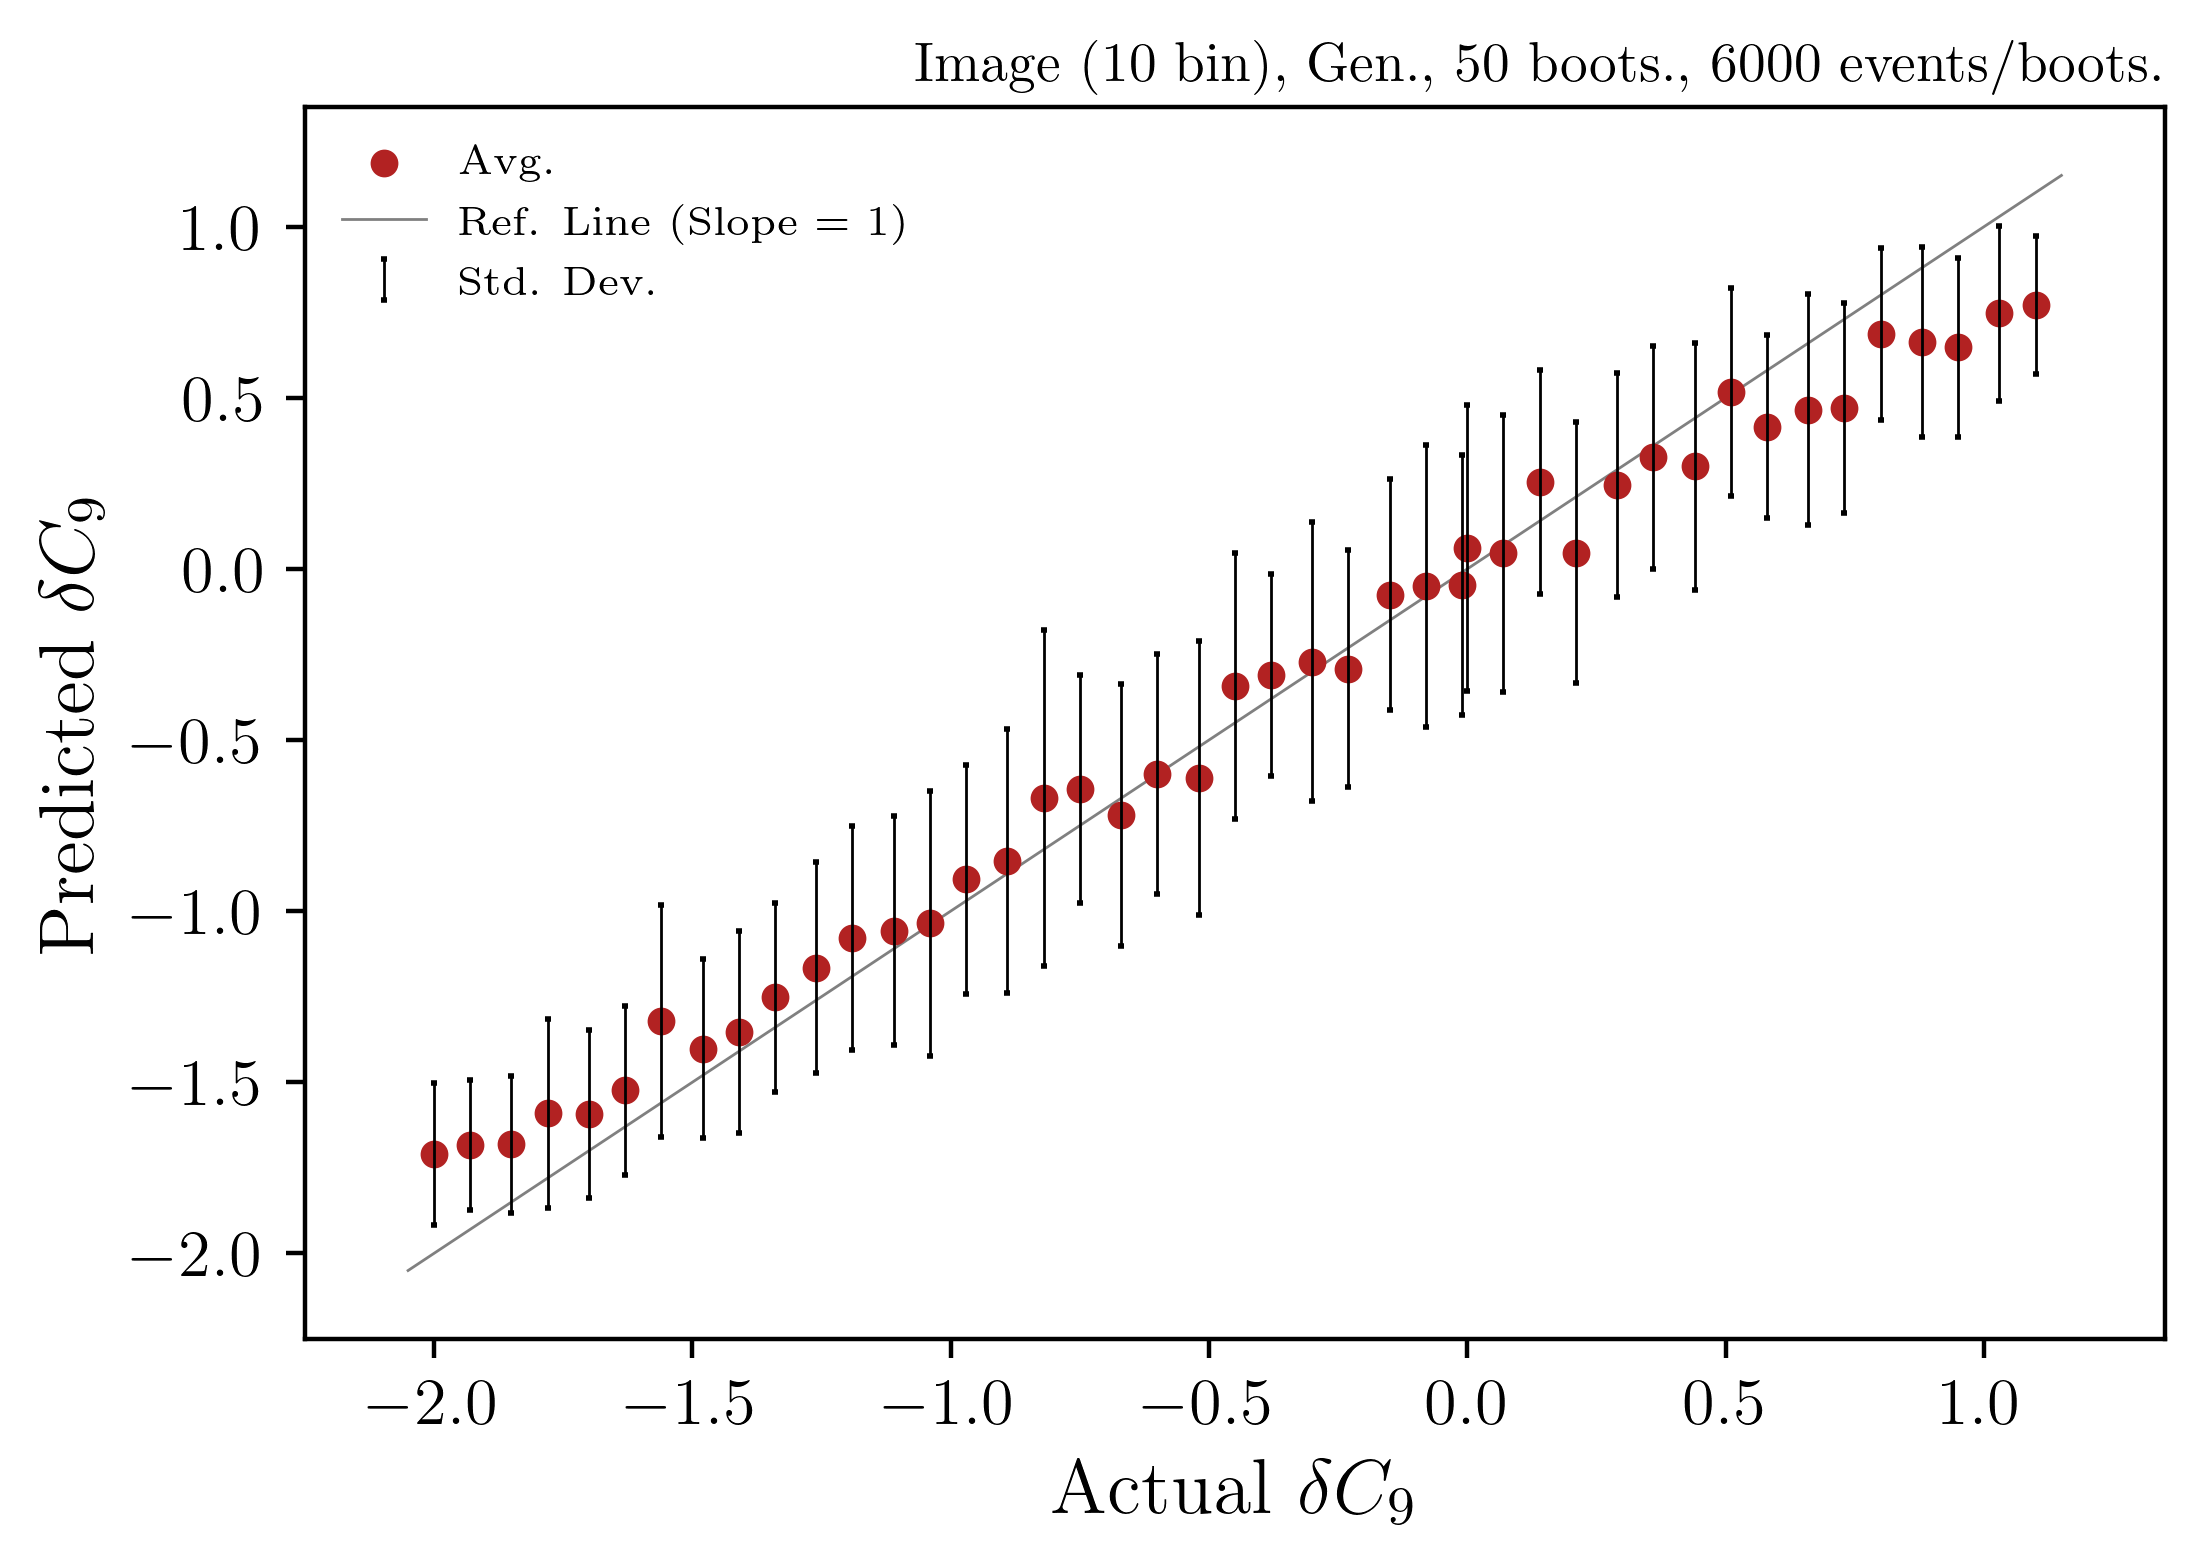

In [13]:
setup_high_quality_mpl_params()

num_sets_per_label = 50

for num_events_per_set in [70_000, 24_000, 6_000]:
    
    nickname = f"cnn_res_v2_{num_events_per_set}"
    model = CNN_Res(nickname, "../../state/new_physics/models")
    model.load_final()
    model.to(device)
    model.eval()
    
    eval_dataset = Signal_Images_Dataset(
        name=f"signal_images_{num_events_per_set}", 
        level="gen", split="eval", 
        save_dir="../../state/new_physics/data/processed"
    )
    eval_dataset.load()
    eval_dataset.to(device)

    with torch.no_grad():
        
        yhat = model(eval_dataset.features)
        avgs = yhat.reshape(-1, num_sets_per_label).mean(1).detach().cpu().numpy()
        stds = yhat.reshape(-1, num_sets_per_label).std(1).detach().cpu().numpy()

        y = eval_dataset.labels
        unique_y = y.reshape(-1, num_sets_per_label).mean(1).detach().cpu().numpy()

        def calc_mse():
            dif = yhat.detach().cpu().numpy() - y.detach().cpu().numpy()
            dif_sq = dif**2
            out = dif_sq.mean()
            return out
        mse = calc_mse()

        def calc_mae():
            dif = yhat.detach().cpu().numpy() - y.detach().cpu().numpy()
            abs_dif = np.abs(dif)
            out = abs_dif.mean()
            return out
        mae = calc_mae()
        
    print("mse:", mse)
    print("mae:", mae)

    fig, ax = plt.subplots()

    plot_prediction_linearity(
        ax,
        unique_y,
        avgs,
        stds,
        ref_line_buffer=0.05,
        xlim=(-2.25, 1.35),
        ylim=(-2.25, 1.35),
        xlabel=r"Actual $\delta C_9$", 
        ylabel=r"Predicted $\delta C_9$"
    )
    make_plot_note(
        ax, 
        (
            "Image (10 bin), Gen., "
            + f"{num_sets_per_label} boots., "
            + f"{num_events_per_set} events/boots."
        ), 
        fontsize="medium"
    )

    plt.show()
    plt.close()

#### Sensitivity

Generate single label dataset

In [9]:
level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"
std_scale = True
q_squared_veto = True
balanced_classes = True
n_bins = 10
num_sets_per_label = 2_000

for num_events_per_set in [70_000, 24_000, 6_000]:

    single_label_eval_dataset = Signal_Images_Dataset(
        name=f"signal_images_{num_events_per_set}_at_-0.82",
        level=level, split="eval", 
        save_dir=save_dir
    )
    single_label_eval_dataset.generate(
        raw_trials=range(21,41), 
        raw_signal_dir=raw_signal_dir,
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        n_bins=n_bins,
        q_squared_veto=q_squared_veto,
        std_scale=std_scale,
        balanced_classes=balanced_classes,
        labels_to_sample=[-0.82],
    )
    

opened raw file: [1/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_21_re.pkl
opened raw file: [2/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_22_re.pkl
opened raw file: [3/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_23_re.pkl
opened raw file: [4/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_24_re.pkl
opened raw file: [5/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_25_re.pkl
opened raw file: [6/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_26_re.pkl
opened raw file: [7/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_27_re.pkl
opened raw file: [8/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_28_re.pkl
opened raw file: [9/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_29_re.pkl
opened raw file: [10/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_30_re.pkl
opened raw file: [11/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_31_re.pkl
opened raw file: [12/879] ..\..\state\new_physics\data\raw\sign

Loaded features of shape: torch.Size([2000, 1, 10, 10, 10]).
Loaded labels of shape: torch.Size([2000]).
Sent features and labels to cuda.
bias:  0.03
std:  0.119


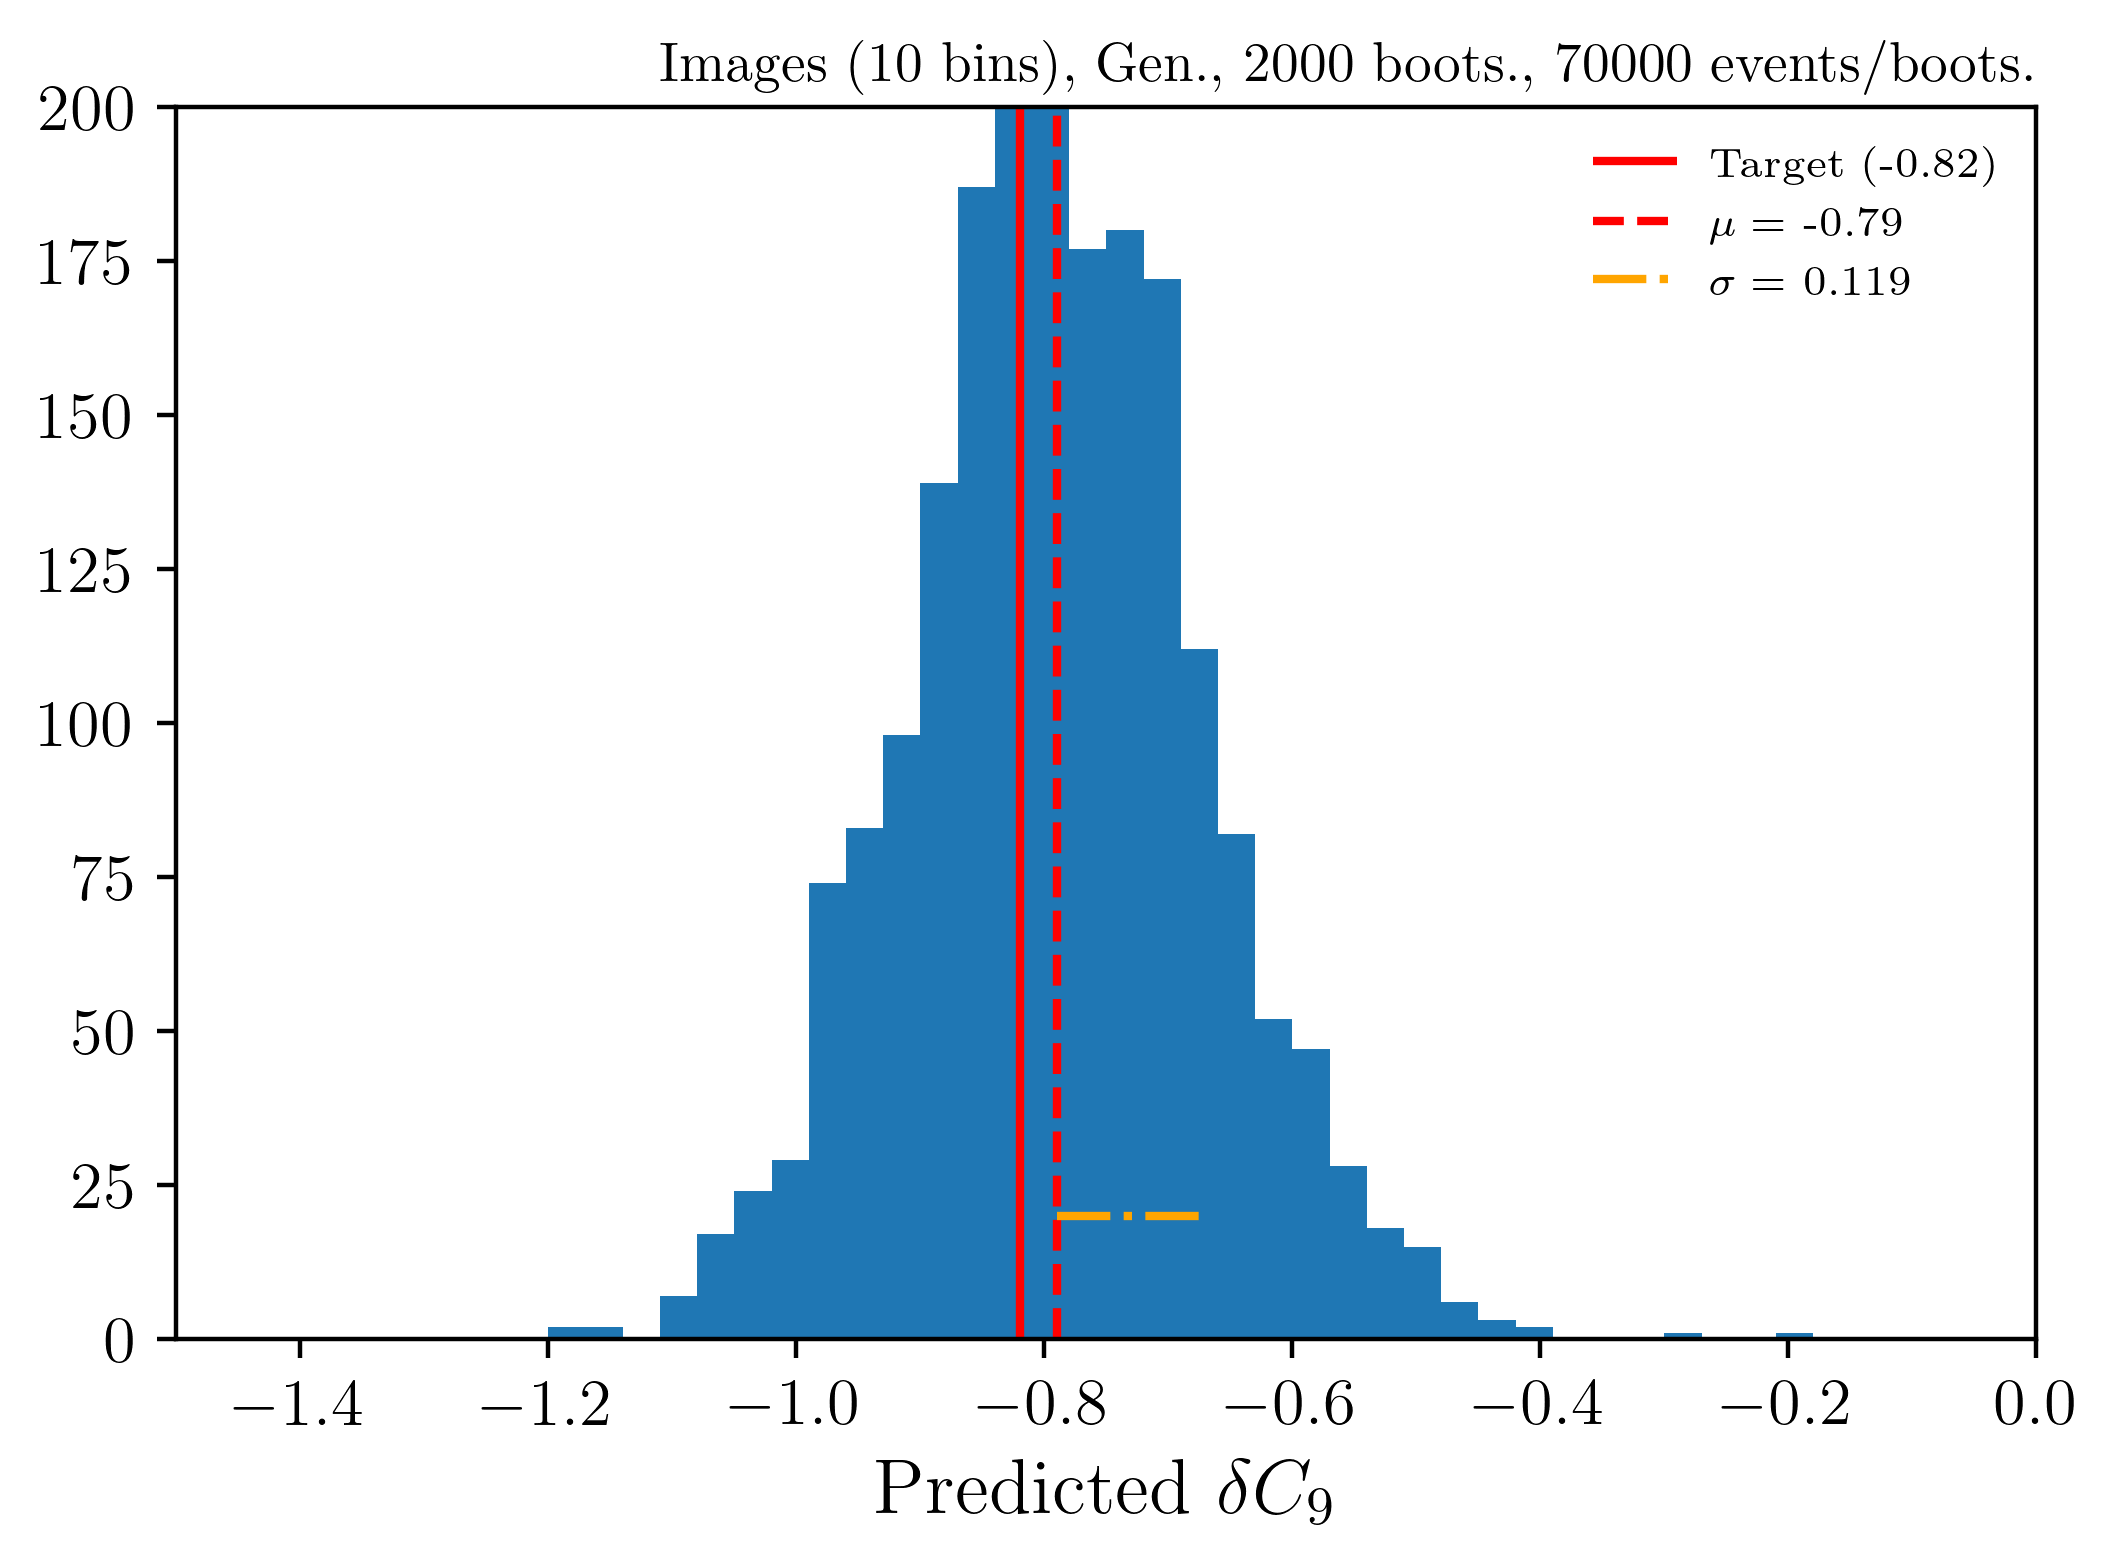

Loaded features of shape: torch.Size([2000, 1, 10, 10, 10]).
Loaded labels of shape: torch.Size([2000]).
Sent features and labels to cuda.
bias:  -0.035
std:  0.164


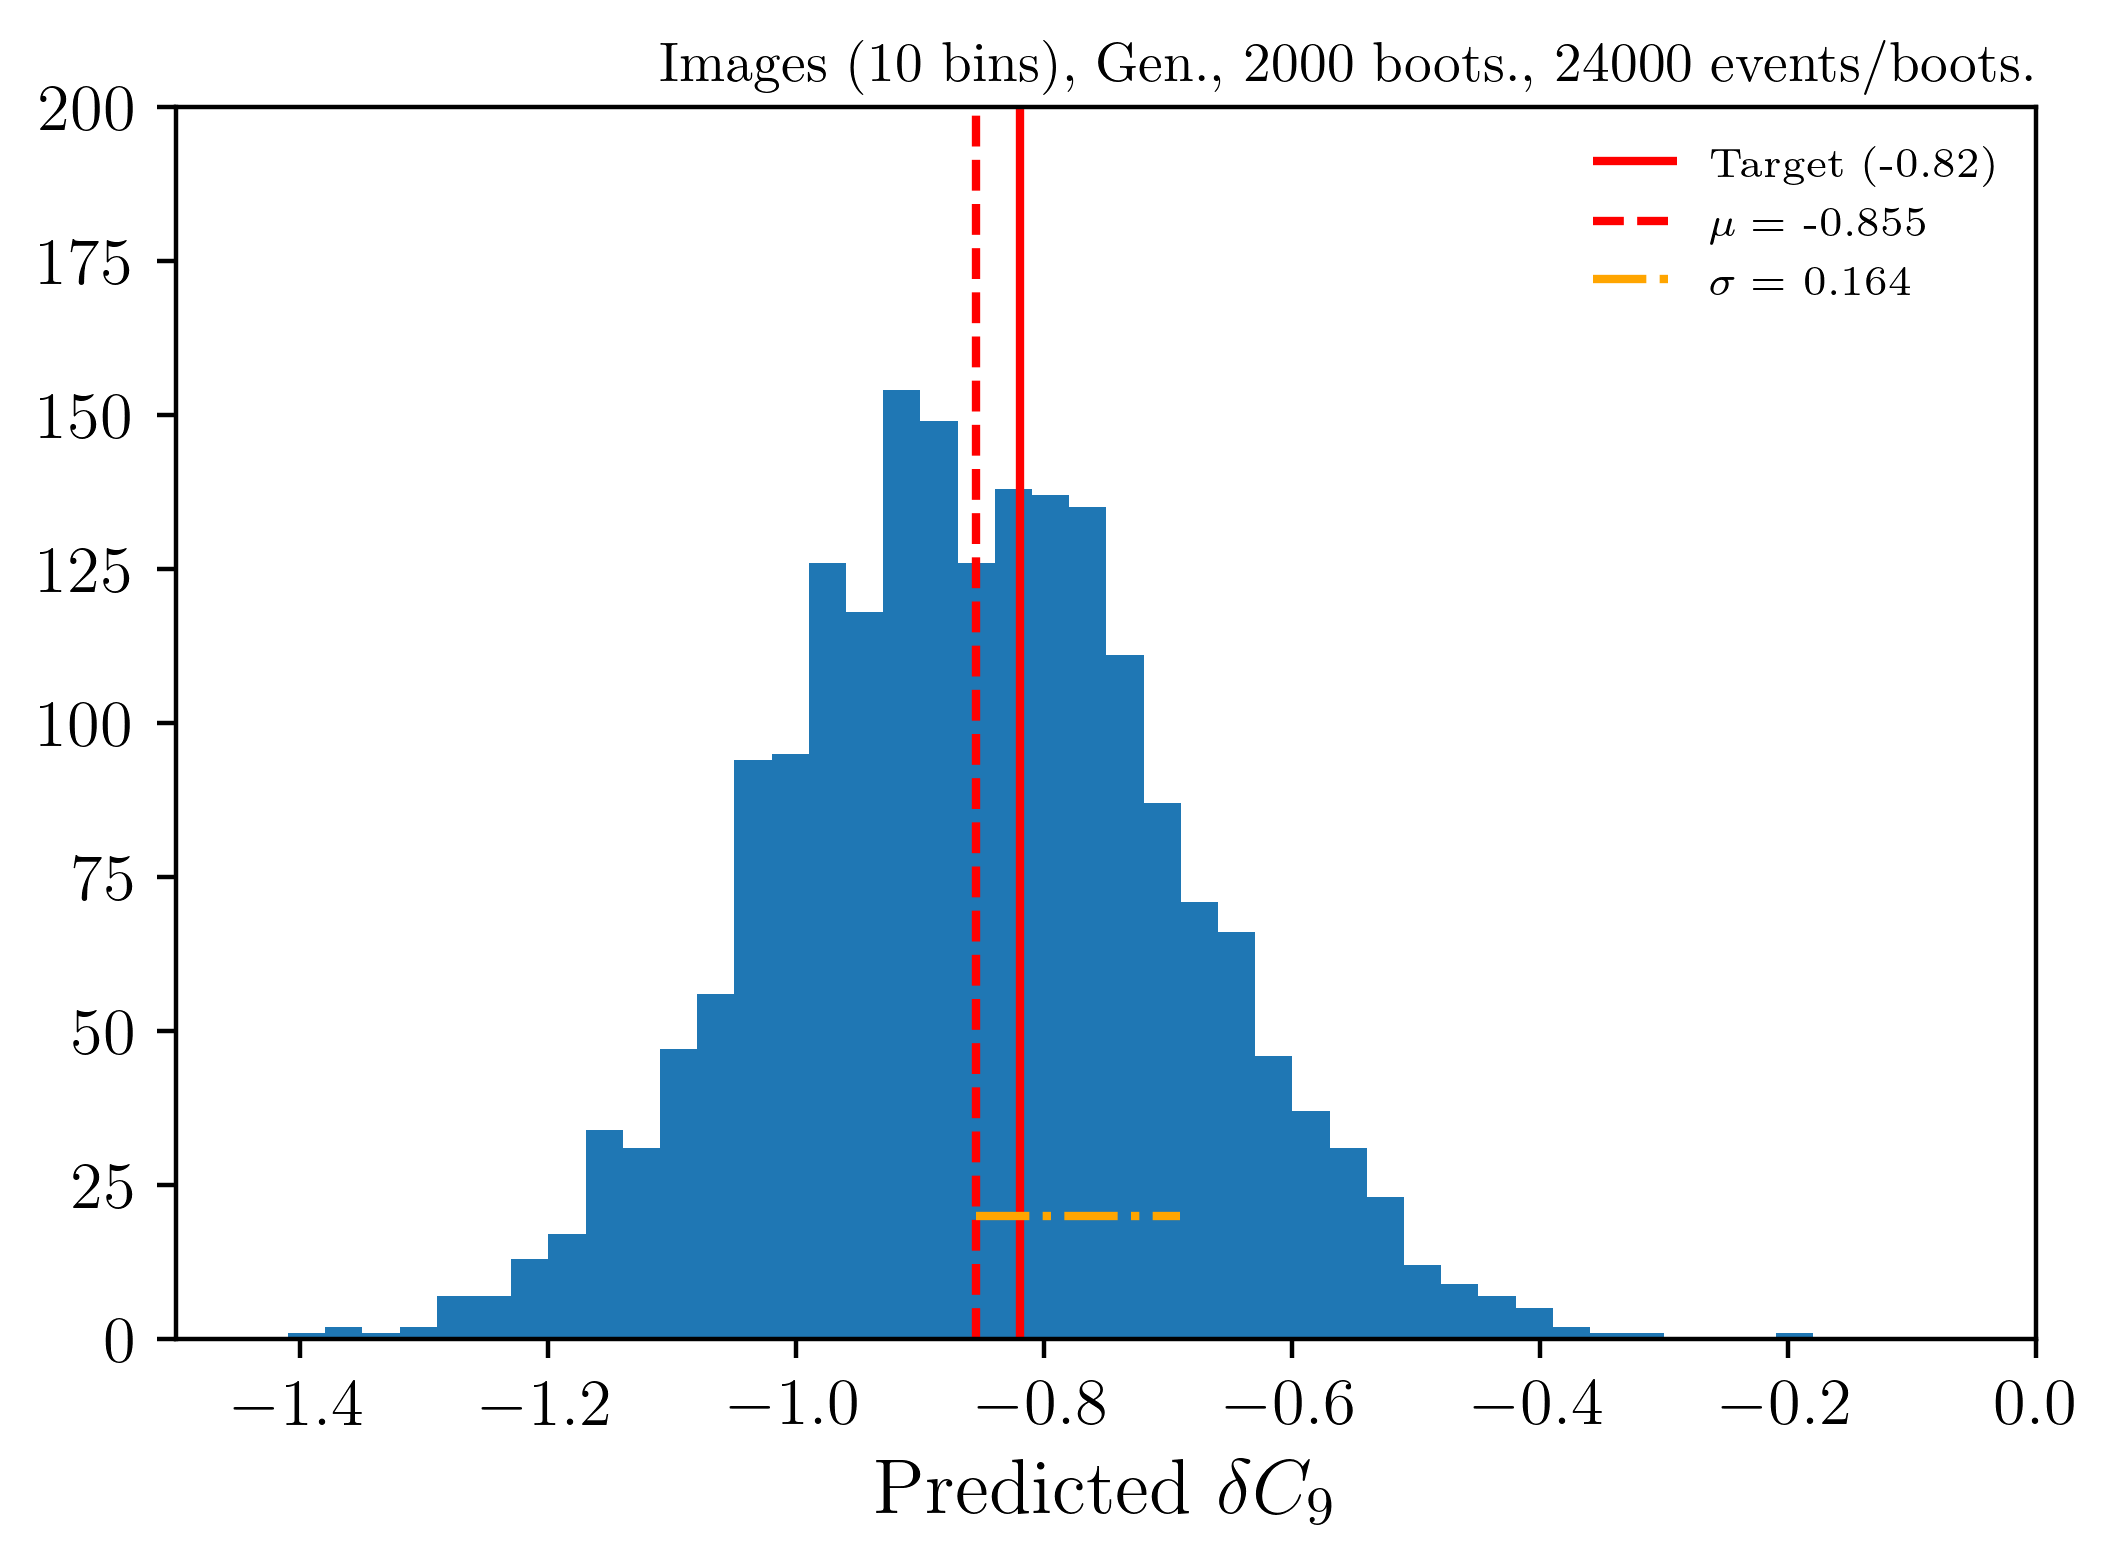

Loaded features of shape: torch.Size([2000, 1, 10, 10, 10]).
Loaded labels of shape: torch.Size([2000]).
Sent features and labels to cuda.
bias:  0.104
std:  0.381


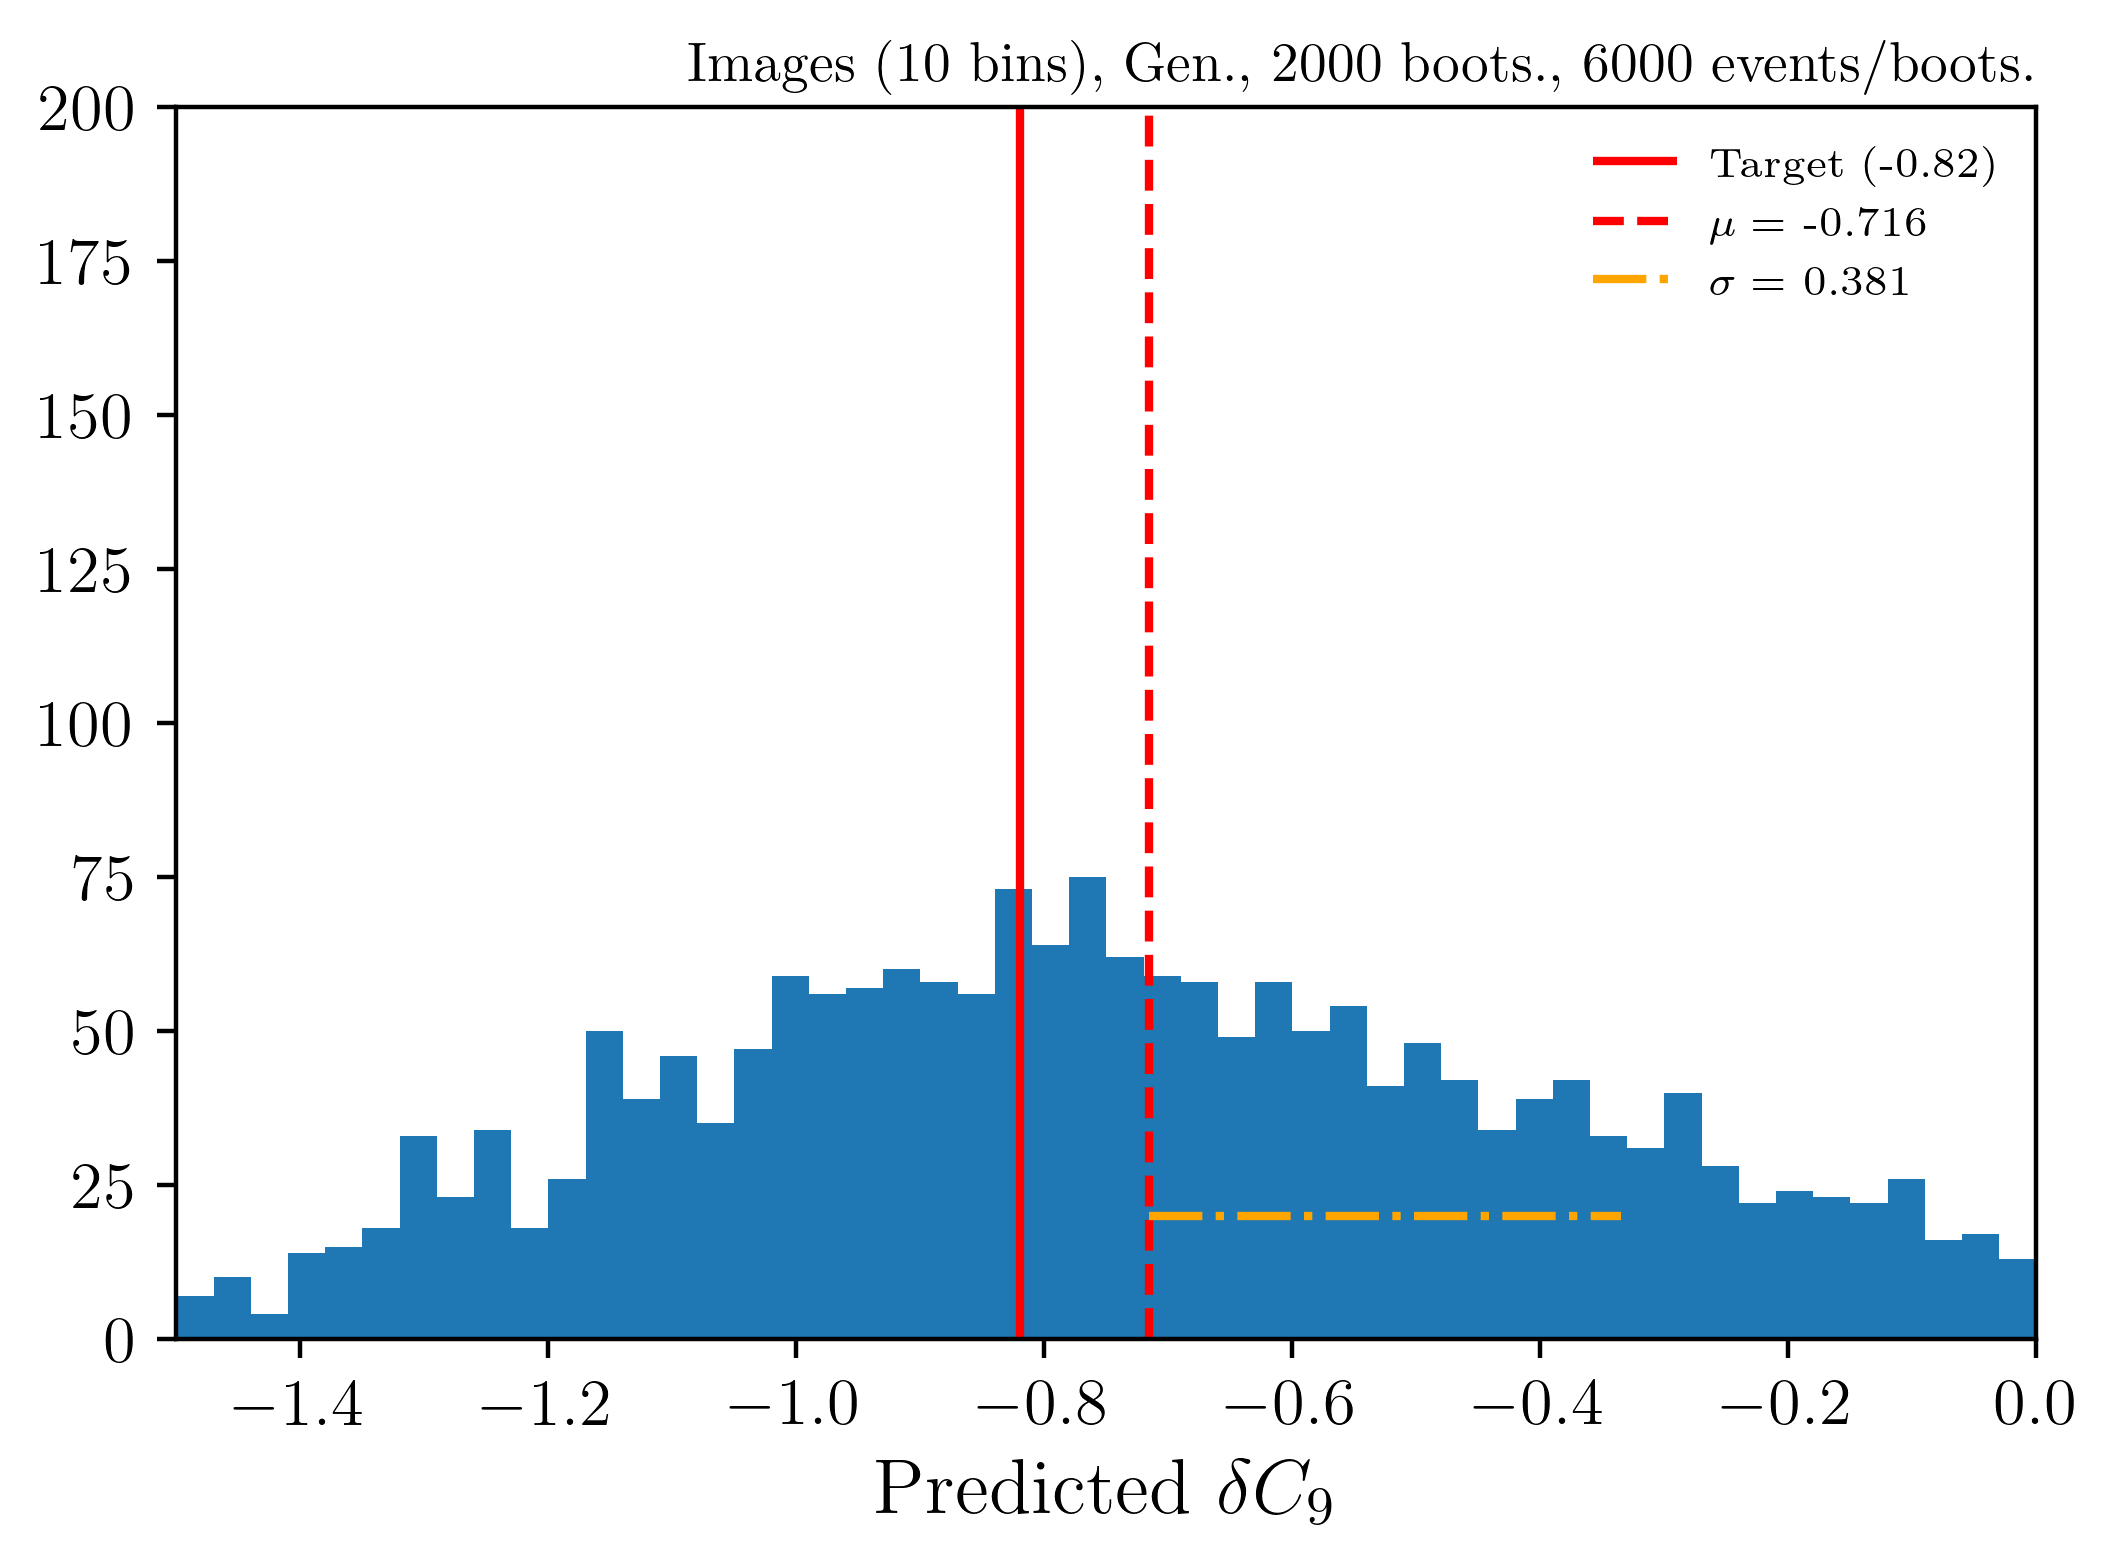

In [15]:
setup_high_quality_mpl_params()

num_sets_per_label = 2000

for num_events_per_set in [70_000, 24_000, 6_000]:
    single_label_eval_dataset = Signal_Images_Dataset(
        name=f"signal_images_{num_events_per_set}_at_-0.82",
        level=level, split="eval", 
        save_dir=save_dir
    )
    single_label_eval_dataset.load()
    single_label_eval_dataset.to(device)

    nickname = f"cnn_res_v2_{num_events_per_set}"
    model = CNN_Res(nickname, "../../state/new_physics/models")
    model.load_final()
    model.to(device)
    model.eval()

    with torch.no_grad():
        yhats = []
        for feat in single_label_eval_dataset.features:
            yhat = model(feat.unsqueeze(0))
            yhats.append(yhat.detach().cpu())
        yhats = np.array(yhats)
        mean = yhats.mean()
        std = yhats.std()
        bias = mean - -0.82

    print("bias: ", bias.round(3))
    print("std: ", std.round(3))

    fig, ax = plt.subplots()

    xbounds = (-1.5, 0)
    ybounds = (0, 200)

    ax.hist(yhats, bins=50, range=xbounds)
    ax.vlines(-0.82, 0, ybounds[1], color="red", label="Target (-0.82)")
    ax.vlines(mean, 0, ybounds[1], color="red", linestyles="--", label=r"$\mu = $ "+f"{mean.round(3)}")
    ax.hlines(20, mean, mean+std, color="orange", linestyles="dashdot", label=r"$\sigma = $ "+f"{std.round(3)}")
    ax.set_xlabel(r"Predicted $\delta C_9$")
    make_plot_note(ax, f"Images (10 bins), Gen., {num_sets_per_label} boots., {num_events_per_set} events/boots.", fontsize="medium")
    ax.set_xbound(*xbounds)
    ax.set_ybound(*ybounds)
    ax.legend()
    plt.show()
    plt.close()

## Deep Sets

### Model Training

#### Generate Datasets

In [ ]:
regenerate = False

level = "gen"
save_dir = "../../state/new_physics/data/processed"

common_generate_kwargs = {
    "raw_signal_dir": "../../state/new_physics/data/raw/signal",
    "std_scale": True,
    "q_squared_veto": True,
    "balanced_classes": True,
    "num_events_per_set": 6_000,
    "num_sets_per_label": 50,
}

datasets = {
    "train": Bootstrapped_Signal_Unbinned_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Bootstrapped_Signal_Unbinned_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(1,21), 
        **common_generate_kwargs
    )
    datasets["eval"].generate(
        raw_trials=range(21,41), 
        **common_generate_kwargs
    )

datasets["train"].load(device)
datasets["eval"].load(device)

# datasets["train"].features = torch.transpose(datasets["train"].features, dim0=1, dim1=2)
# datasets["eval"].features = torch.transpose(datasets["eval"].features, dim0=1, dim1=2)

# print(f"new train features shape: {datasets["train"].features.shape}")
# print(f"new eval features shape: {datasets["eval"].features.shape}")


#### Model Definition

In [ ]:
class Res_Block_Event(nn.Module):
    def __init__(self, in_out_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.LayerNorm(normalized_shape=(num_events_per_set, in_out_features)),
            nn.ReLU(),
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.LayerNorm(normalized_shape=(num_events_per_set, in_out_features)),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        x = self.block(x) #+ x
        x = self.last_activation(x)
        return x


class Res_Block_Set(nn.Module):
    def __init__(self, in_out_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.BatchNorm1d(num_features=in_out_features),
            nn.ReLU(),
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.BatchNorm1d(num_features=in_out_features),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        x = self.block(x) #+ x
        x = self.last_activation(x)
        return x


class Deep_Sets(Custom_Model):
    def __init__(self, nickname, model_dir):
        super().__init__(nickname, model_dir)

        self.f = nn.Sequential(
            nn.Linear(in_features=4, out_features=32),
            # nn.LayerNorm(normalized_shape=(num_events_per_set, 32)),
            nn.ReLU(),
            *[Res_Block_Event(in_out_features=32) for _ in range(3)],
            nn.Linear(in_features=32, out_features=32),
            # nn.LayerNorm(normalized_shape=(num_events_per_set,32)),
        )

        self.g = nn.Sequential(
            *[Res_Block_Set(in_out_features=32) for _ in range(3)],
            nn.Linear(in_features=32, out_features=32),
            # nn.BatchNorm1d(num_features=32), 
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
        )
        
        self.double()

    def forward(self, x):
        x = self.f(x)
        x = torch.mean(x, dim=1)
        x = self.g(x)
        x = torch.squeeze(x)
        return x

#### Training

In [ ]:
retrain = False

nickname = f"deep_sets_{common_generate_kwargs["num_events_per_set"]}"

model = Deep_Sets(nickname, "../../state/new_physics/models")

if retrain:
    learning_rate = 4e-4
    epochs = 80
    train_batch_size = 32
    eval_batch_size = 32
    loss_fn = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler=ReduceLROnPlateau(optimizer, factor=0.9, patience=1),
        checkpoint_epochs=5,
    )
    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(
        model.loss_table["epoch"][plot_epoch_start:], 
        model.loss_table["train_loss"][plot_epoch_start:], 
        model.loss_table["eval_loss"][plot_epoch_start:], 
        ax
    )
    ax.set_yscale("log")
    plt.show()
else:
    pass
    # model.load_final()
    # model.load_checkpoint(epoch_number=10)
    # model.to(device)

### Evaluation

#### Linearity

In [ ]:
print("Final: ")

setup_high_quality_mpl_params()

model.load_final()
model.to(device)

model.eval()
with torch.no_grad():
    
    yhats = []
    for feat in datasets["eval"].features:
        feat = feat.unsqueeze(0)
        yhat = model(feat)
        yhats.append(yhat)

    yhats = torch.tensor(yhats)
    avgs = yhats.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    stds = yhats.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

    y = datasets["eval"].labels
    unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    unique_y

    def calc_mse():
        dif = yhats.detach().cpu().numpy() - y.detach().cpu().numpy()
        dif_sq = dif**2
        out = dif_sq.mean()
        return out

    def calc_mae():
        dif = yhats.detach().cpu().numpy() - y.detach().cpu().numpy()
        abs_dif = np.abs(dif)
        out = abs_dif.mean()
        return out
    
    print("mse:", calc_mse())
    print("mae:", calc_mae())

    fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    unique_y,
    avgs,
    stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, f"Deep Sets, Gen., {common_generate_kwargs["num_sets_per_label"]} boots., {common_generate_kwargs["num_events_per_set"]} events/boots.", fontsize="medium")

plt.show()
plt.close()

#### Sensitivity

In [ ]:
regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"
num_events_per_set = 24_000
num_sets_per_label = 2_000

single_eval_dset = Bootstrapped_Signal_Unbinned_Single_Dataset(level=level, split="eval", save_dir=save_dir)

if regenerate:
    single_eval_dset.generate(
        raw_trials=range(21,41), 
        raw_signal_dir="../../state/new_physics/data/raw/signal",
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        label_value=-0.82,
    )

single_eval_dset.load()

with torch.no_grad():
    yhats = []
    for s in single_eval_dset.features:
        yhat = model(s.unsqueeze(0).to(device))
        yhats.append(yhat.detach().cpu())
    yhats = np.array(yhats)

    mean = yhats.mean()
    std = yhats.std()

fig, ax = plt.subplots()

xbounds = (-1.5, 0)
ybounds = (0, 200)

ax.hist(yhats, bins=50, range=xbounds)
ax.vlines(-0.82, 0, ybounds[1], color="red", label="Target (-0.82)")
ax.vlines(mean, 0, ybounds[1], color="red", linestyles="--", label=r"$\mu = $ "+f"{mean.round(3)}")
ax.hlines(100, mean, mean+std, color="orange", linestyles="dashdot", label=r"$\sigma = $ "+f"{std.round(3)}")
ax.set_xlabel(r"Predicted $\delta C_9$")
make_plot_note(ax, f"Deep Sets, Gen., {num_sets_per_label} boots., {num_events_per_set} events/boots.", fontsize="medium")
ax.set_xbound(*xbounds)
ax.set_ybound(*ybounds)
ax.legend()
plt.show()

## Event-by-event Method

### Datasets

In [ ]:
regenerate = False

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

std_scale = True
q_squared_veto = True

datasets = {
    "train": Aggregated_Signal_Binned_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Aggregated_Signal_Binned_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(1,20), 
        raw_signal_dir=raw_signal_dir, 
        std_scale=std_scale, 
        q_squared_veto=q_squared_veto
    )
    datasets["eval"].generate(
        raw_trials=range(20,40), 
        raw_signal_dir=raw_signal_dir, 
        std_scale=std_scale, 
        q_squared_veto=q_squared_veto
    )

datasets["train"].load(device)
datasets["eval"].load(device)

np.testing.assert_equal(datasets["train"].bin_values, datasets["eval"].bin_values)

### Model Training

In [ ]:
class Event_By_Event_NN(Custom_Model):
    def __init__(self, nickname, model_dir):
        super().__init__(nickname, model_dir)

        self.base = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 44),
         )
        
        self.double()

    def forward(self, x):
        event_logits = self.base(x)
        return event_logits


retrain = False

model = Event_By_Event_NN("event_by_event_nn", "../../state/new_physics/models")

if retrain:
    learning_rate = 3e-3
    epochs = 200
    train_batch_size = 10_000
    eval_batch_size = 10_000
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=True,
        scheduler= ReduceLROnPlateau(optimizer, factor=0.95, threshold=0, patience=0, eps=1e-9),
        checkpoint_epochs=5,
    )
    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(loss_table["epoch"][plot_epoch_start:], loss_table["train_loss"][plot_epoch_start:], loss_table["eval_loss"][plot_epoch_start:], ax)
    ax.set_yscale("log")
    plt.show()
else:
    model.load_final()
    # model.load_checkpoint(epoch_number=10)
    model.to(device)



### Evaluation

In [ ]:
n_trials = 2000
n_events_per_trial = 70_000

expected_values_all_trials = []
for _ in range(n_trials):

    boot_x, boot_y = bootstrap_over_bins(
        datasets["eval"].features.cpu().numpy(), 
        datasets["eval"].labels.cpu().numpy(), 
        n_events_per_trial,
    )
    boot_x = torch.from_numpy(boot_x).to(device)
    boot_y = torch.from_numpy(boot_y).to(device)

    log_probs = predict_log_probabilities_by_label(boot_x, boot_y, model)
    expected_values = calculate_predicted_expected_value_by_label(log_probs, datasets["eval"].bin_values)
    expected_values_all_trials.append(np.expand_dims(expected_values, axis=0))

expected_values_all_trials = np.concat(expected_values_all_trials)

def calc_mse():
    dif = expected_values_all_trials - datasets["eval"].bin_values
    dif_sq = dif**2
    out = dif_sq.mean()
    return out

def calc_mae():
    dif = expected_values_all_trials - datasets["eval"].bin_values
    abs_dif = np.abs(dif)
    out = abs_dif.mean()
    return out

mse = calc_mse()
mae = calc_mae()
print("mse:", mse)
print("mae:", mae)


expected_values_all_trials_means = np.mean(expected_values_all_trials, axis=0)
expected_values_all_trials_stds = np.std(expected_values_all_trials, axis=0)

setup_high_quality_mpl_params()

fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    datasets["eval"].bin_values,
    expected_values_all_trials_means,
    expected_values_all_trials_stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)

make_plot_note(ax, f"Event-by-event, Gen., {n_trials} boots., {n_events_per_trial} events/boots.", fontsize="medium")

plt.show()

In [ ]:
n_events_per_set = 6_000
n_sets = 2000

target_bin_index = np.argwhere(datasets["eval"].bin_values==-0.82).item()
rng = np.random.default_rng()

pool_x = datasets["eval"].features[datasets["eval"].labels==target_bin_index]
pool_y = datasets["eval"].labels[datasets["eval"].labels==target_bin_index]

yhats = []
for _ in range(n_sets):
    selection_indices = rng.choice(len(pool_x), n_events_per_set)
    boot_x = pool_x[selection_indices]
    boot_y = pool_y[selection_indices]

    log_probs = predict_log_probabilities(boot_x, model)
    bin_values = datasets["eval"].bin_values + 5
    log_bin_values = np.log(bin_values)
    lse = logsumexp(log_bin_values + log_probs.cpu().numpy())
    yhat = np.exp(lse) - 5
    yhats.append(yhat)

yhats = np.array(yhats)

mean= yhats.mean()
std = yhats.std()

setup_high_quality_mpl_params()
fig, ax = plt.subplots()

xbounds = (-1.5, 0)
ybounds = (0, 200)

ax.hist(yhats, bins=50, range=xbounds)
ax.vlines(-0.82, 0, ybounds[1], color="red", label="Target (-0.82)")
ax.vlines(mean, 0, ybounds[1], color="red", linestyles="--", label=r"$\mu = $ "+f"{mean.round(3)}")
ax.hlines(20, mean, mean+std, color="orange", linestyles="dashdot", label=r"$\sigma = $ "+f"{std.round(3)}")
ax.set_xlabel(r"Predicted $\delta C_9$")
make_plot_note(ax, f"Event-by-event, Gen., {n_sets} boots., {n_events_per_set} events/boots.", fontsize="medium")
ax.set_xbound(*xbounds)
ax.set_ybound(*ybounds)
ax.legend()


plt.show()

# Detector Level

## Shawn's Method

### Datasets

### Model Training

### Evaluation

## Deep Sets

### Datasets

### Model Training

### Evaluation

## Event-by-event Method

### Datasets

### Model Training

### Evaluation

# Detector Level with Backgrounds

## Shawn's Method

## Deep Sets

## Event-by-event Method

In [ ]:

def predict_log_probabilities(x, model):
    """
    Predict the log probability of each class, given a set of events.

    x : A torch tensor of features of events.
    """
    model.eval()
    with torch.no_grad():
        event_logits = model(x)
        event_log_probabilities = torch.nn.functional.log_softmax(event_logits, dim=1)
        set_logits = torch.sum(event_log_probabilities, dim=0)
        set_log_probabilities = torch.nn.functional.log_softmax(set_logits, dim=0)
    return set_log_probabilities


def predict_log_probabilities_by_label(x, y, model):
    """
    Predict the log probability of each class for each subset of same labeled events.
    
    x : A torch tensor of features of events (from multiple labels).
    y : A torch tensor of event labels.
    """
    labels = np.unique(y.cpu())
    log_probabilities = []
    for label in labels:
        features_label = x[y==label]
        log_probabilities_label = predict_log_probabilities(features_label, model).cpu().numpy()
        log_probabilities.append(np.expand_dims(log_probabilities_label, axis=0))
    log_probabilities = np.concatenate(log_probabilities, axis=0)
    assert log_probabilities.shape[0] == len(labels)
    return log_probabilities


def calculate_predicted_expected_value_by_label(predictions, bin_values):
    """
    Calculate the predicted expected binned value for each subset of same labeled events, given 
    the predicted probability distribution for each subset.

    predictions : numpy array of predicted probability distributions for each label.
    bin_values : numpy array of the value corresponding to each bin.
    """
    bin_value_shift = np.abs(np.min(bin_values)) + 1
    shifted_bin_values = bin_values + bin_value_shift
    log_shifted_bin_values = np.tile(np.log(shifted_bin_values), (len(shifted_bin_values), 1))
    log_shifted_expected_values = scipy.special.logsumexp(predictions + log_shifted_bin_values, axis=1)
    shifted_expected_values = np.exp(log_shifted_expected_values)
    expected_values = shifted_expected_values - bin_value_shift
    return expected_values


def plot_log_probabilities_over_labels(fig, ax, predictions, bin_values, cmap=plt.cm.viridis):
    """
    Plot the predicted log probability of each class for each subset of same labeled events.

    predictions : A numpy array of set probabilities (rows correspond to labels, columns correspond to class predictions).
    bin_values : A numpy array of the value each bin represents. 
    """

    color_bounds = np.append(bin_values, bin_values[-1] + (bin_values[-1] - bin_values[-2]))
    color_norm = mpl.colors.BoundaryNorm(color_bounds, cmap.N)

    for value, curve in zip(bin_values, predictions):
        ax.plot(bin_values, curve, color=cmap(color_norm(value)))

    fig.colorbar(mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap), ax=ax, label=r"Actual $\delta C_9$")
    ax.set_xlabel(r"$\delta C_9$")
    ax.set_ylabel(r"$\log p(\delta C_9 | x_1, ..., x_N)$")


def plot_expected_value_over_labels(ax, expected_values, bin_values):
    """
    Plot the predicted expected value for each label.
    """
    ax.scatter(bin_values, expected_values, label="Prediction", color="firebrick", s=16, zorder=5)
    ax.plot(
        bin_values, bin_values,
        label="Ref. Line (Slope = 1)",
        color="grey",
        linewidth=0.5,
        zorder=0
    )
    ax.set_xlabel(r"Actual $\delta C_9$")
    ax.set_ylabel(r"Predicted $\delta C_9$")
    ax.legend()
